In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import numpy as np

In [2]:
from pathlib import Path

## Dataset

The dataset is a set of audio recordings from cats. Samples are short clips (1-2 seconds) grouped in three classes:
- brushing the cat
- cat is in unfamiliar environment (discomfort)
- waiting for food

Source: https://zenodo.org/record/4008297 <br>
Paper: https://air.unimi.it/handle/2434/811133

In [3]:
dataset_dir = Path('/home/flo/projects/data-playground/data/catmeows/wav')
dataset_png = dataset_dir.parent / 'png'

## Convert audio samples into images of spectograms

In [4]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

# source: https://stackoverflow.com/questions/47954034/plotting-spectrogram-in-audio-analysis/47954408
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def wav_to_png(path_wav, overwrite=False):
    path_png = dataset_png / f'{path_wav.stem}.png'
    
    if path_png.exists() and not overwrite:
        return path_png

    # read wave file
    sample_rate, audio = wavfile.read(path_wav)

    # turn audio into spectogram
    freqs, times, specgram = log_specgram(audio, sample_rate)

    # bring into range 0..255
    specgram_normed = (specgram + abs(specgram.min())) / (abs(specgram.min()) + specgram.max())
    specgram_normed = (specgram_normed * 255).astype(np.uint8) 

    # save as image
    if write:
        data = Image.fromarray(specgram_normed)
        data.save(path_png)


In [6]:
paths_wav = list(dataset_dir.glob('*.wav'))
paths_png = [
    wav_to_png(path_wav)
    for path_wav
    in paths_wav
]

## Look at some example spectrograms

In [7]:
import IPython

def show_sample(idx):
    IPython.display.display(IPython.display.Audio(paths_wav[idx]))
    IPython.display.display(IPython.display.Image(paths_png[idx]))

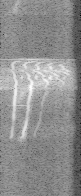

In [8]:
show_sample(24)

## Inspect (some) shapes

In [9]:
for idx in range(5):
    print(np.array(Image.open(paths_png[idx])).shape)

(140, 81)
(125, 81)
(150, 81)
(155, 81)
(161, 81)


## DataLoader

In [10]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [11]:
# from torchvision import transforms
# transforms.Pad

This is what a loaded image looks like (when loaded as PILImageBW, we have no color channels)

In [12]:
np.array(PILImage.create(paths_png[0])).shape

(140, 81, 3)

In [13]:
np.array(PILImageBW.create(paths_png[0])).shape

(140, 81)

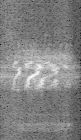

In [14]:
PILImageBW.create(paths_png[0])

DataLoader:

In [15]:
label_dict = {
    'B': 'brushing',
    'F': 'hungry',
    'I': 'discomfort'
}
def label_func(fname):
    # B = brushing; F = waiting for food; I: isolation in an unfamiliar environment);
    return label_dict[fname.name[0]]

def get_dataloaders(batch_size=128):
    data = DataBlock(
        blocks=(ImageBlock(cls=PILImage), CategoryBlock),
#         n_inp=1,  # how many blocks are input
        get_items=get_image_files,
        splitter=RandomSplitter(),  # TODO: clean split so that same cats doesn't appear in both sets
        item_tfms=[CropPad(81)],
        #         item_tfms=[Resize(81, method=ResizeMethod.Crop)],  # transforms.Pad(8), transforms.CenterCrop(81)
        get_y=label_func, 
    )
    
    return data, data.dataloaders(dataset_png, bs=batch_size)
datablock, dls = get_dataloaders()

In [16]:
datablock.summary(dataset_png)

Setting-up type transforms pipelines
Found 440 items
2 datasets of sizes 352,88
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/flo/projects/data-playground/data/catmeows/png/I_MEG01_MC_FI_SIM01_306.png
    applying PILBase.create gives
      PILImage mode=RGB size=81x171
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/flo/projects/data-playground/data/catmeows/png/I_MEG01_MC_FI_SIM01_306.png
    applying label_func gives
      discomfort
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=81x171, TensorCategory(1))


Found 440 items
2 datasets of sizes 352,88
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': Tr

**Looking at first batch:**

In [17]:
dls.one_batch()[0].shape, dls.one_batch()[1].shape

(torch.Size([128, 3, 81, 81]), torch.Size([128]))

In [18]:
one_sample = dls.one_batch()[0][0].cpu()
one_sample

TensorImage([[[0.3922, 0.5098, 0.5490,  ..., 0.2902, 0.3176, 0.2980],
         [0.5373, 0.5333, 0.4824,  ..., 0.2588, 0.2745, 0.2588],
         [0.5020, 0.5451, 0.5176,  ..., 0.3451, 0.3255, 0.2588],
         ...,
         [0.3176, 0.5765, 0.5804,  ..., 0.3020, 0.2627, 0.2353],
         [0.5765, 0.5686, 0.5137,  ..., 0.3216, 0.2784, 0.1137],
         [0.5373, 0.5765, 0.5137,  ..., 0.2980, 0.3098, 0.2392]],

        [[0.3922, 0.5098, 0.5490,  ..., 0.2902, 0.3176, 0.2980],
         [0.5373, 0.5333, 0.4824,  ..., 0.2588, 0.2745, 0.2588],
         [0.5020, 0.5451, 0.5176,  ..., 0.3451, 0.3255, 0.2588],
         ...,
         [0.3176, 0.5765, 0.5804,  ..., 0.3020, 0.2627, 0.2353],
         [0.5765, 0.5686, 0.5137,  ..., 0.3216, 0.2784, 0.1137],
         [0.5373, 0.5765, 0.5137,  ..., 0.2980, 0.3098, 0.2392]],

        [[0.3922, 0.5098, 0.5490,  ..., 0.2902, 0.3176, 0.2980],
         [0.5373, 0.5333, 0.4824,  ..., 0.2588, 0.2745, 0.2588],
         [0.5020, 0.5451, 0.5176,  ..., 0.3451, 0.325

In [19]:
one_sample.min().item(), one_sample.max().item()

(0.09019608050584793, 1.0)

In [20]:
# only works for single-channel
# plt.imshow(one_sample.squeeze(), cmap='gray', vmin=0, vmax=1)

In [21]:
# does this one look closer to what show_batch produces?
# plt.imshow((1./one_sample.squeeze()).log(), cmap='gray')

In [22]:
# how many classes?
dls.c

3

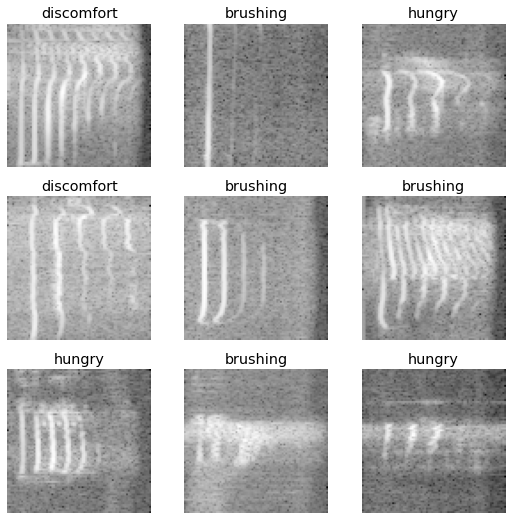

In [23]:
dls.show_batch()

## ConvNet model

In [24]:
class cast_to_tensor(Module):
    "Workoaround: https://github.com/fastai/fastai/issues/2769#issuecomment-824186215"
    def forward(self, x):
        return cast(x, Tensor)

In [25]:



in_shape = (81, 81)  # time, frequencies, channels
n_classes = 3

class Net(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.size())

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def simple_net(arch='classic', n_channels=3):
    if arch == 'classic':
        # a model with a few conv layer and an mlp
#         return Net()
        
        return nn.Sequential(
            nn.Conv2d(n_channels, 16, 5, stride=2),  # -> (8, ?, ?)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2),  # -> (16, ?, ?)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2), # -> (32, 9, 9)
            nn.BatchNorm2d(32),
            nn.Flatten(),
            nn.Linear(32*9*9, 256),
#             nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Linear(256, n_classes),
#             cast_to_tensor()
        )
    
    if arch == 'conv-only':
        # a model with only conv layers. stride=2 to downsample to 1x1 for classification layer
        return nn.Sequential(
            nn.Conv2d(n_channels, 4, 3, stride=2),  # -> (4, 40, 40)
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, stride=2),  # -> (8, 20, 20)
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2), # -> (16, 10, 10)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2), # -> (32, 5, 5)
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2), # -> (32, 2, 2) / (32, 1, 1) (????)
            nn.Conv2d(32, n_classes, 1),
            nn.Flatten(),  # squeeze 1x1 dimensions
            cast_to_tensor()
        )
net = simple_net()
print(net)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=2592, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=3, bias=True)
)


In [26]:

sample = torch.randn(4, 3, 81, 81)
net(sample).shape

torch.Size([4, 3])

In [40]:
learn_lr = Learner(
        dls,
        simple_net(),
#         loss_func=F.cross_entropy,  # <-- breaks confusion matrix for some reason
        metrics=accuracy
    )

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0012022644514217973)

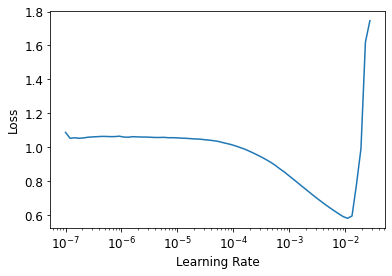

In [41]:
learn_lr.lr_find()

In [45]:
def fit(epochs=20, lr=0.01):
    learn = Learner(
        dls,
        simple_net(),
#         loss_func=F.cross_entropy,
#         loss_func=CrossEntropyLossFlat,
        metrics=accuracy,
        cbs=ActivationStats(with_hist=True)
    )
    learn.fit_one_cycle(epochs, lr)
    return learn


learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.994959,1.064730,0.590909,00:00
1,0.807369,1.047718,0.590909,00:00
2,0.645620,1.053566,0.272727,00:00
3,0.523093,1.277941,0.272727,00:00
4,0.548400,1.077237,0.295455,00:00
5,0.797661,4.349799,0.136364,00:00
6,0.832917,8.296172,0.272727,00:00
7,0.936661,11.706399,0.136364,00:00
8,0.907749,10.376420,0.284091,00:00
9,0.860267,2.935368,0.386364,00:00


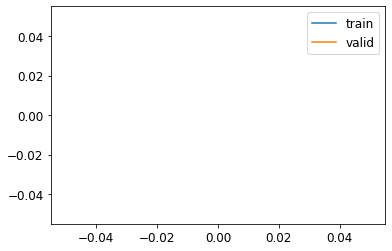

In [50]:
learn.recorder.plot_loss()

In [33]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,ActivationStats]

## Classification results

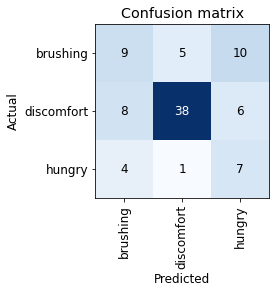

In [49]:
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

### Activations on first layer

In [35]:
# learn.activation_stats.stats

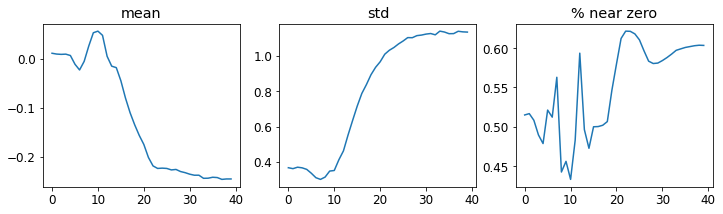

In [46]:
learn.activation_stats.plot_layer_stats(0)

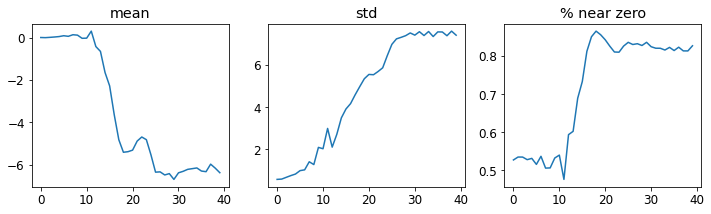

In [47]:
learn.activation_stats.plot_layer_stats(-2)

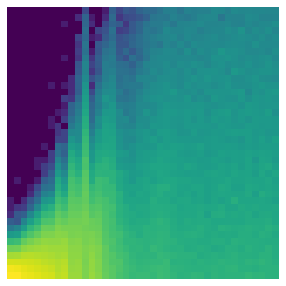

In [48]:
learn.activation_stats.color_dim(-2)